# Analyze logs in Spark using a custom library

This notebook demonstrates how to analyze log data using a custom library with Spark on HDInsight. The custom library we use is a Python library called **iislogparser.py**. This library is already included on the Spark cluster at **/HdiSamples/HdiSamples/WebsiteLogSampleData/iislogparser.py**.

----------
## Notebook setup

When using PySpark kernel notebooks on HDInsight, there is no need to create a SparkContext or a SparkSession; a SparkSession which has the SparkContext is created for you automatically when you run the first code cell, and you'll be able to see the progress printed. The contexts are created with the following variable names:
- SparkSession (spark)

To run the cells below, place the cursor in the cell and then press **SHIFT + ENTER**.

--------

## Save raw data as an RDD

Start with importing some types that are going to be used later in this sample.

In [1]:
from pyspark.sql import Row
from pyspark.sql.types import *

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1597776479924_0002,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


Create an RDD using the sample log data already available on the cluster. You can access the data in the default storage account associated with the cluster at **\HdiSamples\HdiSamples\WebsiteLogSampleData\SampleLog\909f2b.log**.

In [2]:
logs = spark.sparkContext.textFile('wasb:///HdiSamples/HdiSamples/WebsiteLogSampleData/SampleLog/909f2b.log')

Retrieve a sample log set to verify that the previous step completed successfully.

In [3]:
logs.take(5)

[u'#Software: Microsoft Internet Information Services 8.0', u'#Fields: date time s-sitename cs-method cs-uri-stem cs-uri-query s-port cs-username c-ip cs(User-Agent) cs(Cookie) cs(Referer) cs-host sc-status sc-substatus sc-win32-status sc-bytes cs-bytes time-taken', u'2014-01-01 02:01:09 SAMPLEWEBSITE GET /blogposts/mvc4/step2.png X-ARR-LOG-ID=2ec4b8ad-3cf0-4442-93ab-837317ece6a1 80 - 1.54.23.196 Mozilla/5.0+(Windows+NT+6.3;+WOW64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/31.0.1650.63+Safari/537.36 - http://weblogs.asp.net/sample/archive/2007/12/09/asp-net-mvc-framework-part-4-handling-form-edit-and-post-scenarios.aspx www.sample.com 200 0 0 53175 871 46', u'2014-01-01 02:01:09 SAMPLEWEBSITE GET /blogposts/mvc4/step3.png X-ARR-LOG-ID=9eace870-2f49-4efd-b204-0d170da46b4a 80 - 1.54.23.196 Mozilla/5.0+(Windows+NT+6.3;+WOW64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/31.0.1650.63+Safari/537.36 - http://weblogs.asp.net/sample/archive/2007/12/09/asp-net-mvc-framework-part-4-handling

--------

## Analyze log data using a custom Python library

In the output above, the first couple lines include the header information and each remaining line matches the schema described in that header. Parsing such logs could be complicated. So, we use a custom Python library (**iislogparser.py**) that makes parsing such logs much easier. 

However, this is not a Python library that we can install with Pip, and it is not in the `PYTHONPATH`, we cannot use it by using an import statement like `import iislogparser`. To use this library, we must distribute it to all the worker nodes. 

The first step in doing that is to copy it over to the default storage account associated with the cluster. Let us assume you copy it over to `wasb:///HdiSamples/HdiSamples/WebsiteLogSampleData/iislogparser.py`. You must then run the following snippet to distribute the library to all worker nodes in the Spark cluster. 

In [4]:
defaultFS = spark.sparkContext._jsc.hadoopConfiguration().get('fs.defaultFS')
spark.sparkContext.addPyFile(defaultFS + '/HdiSamples/HdiSamples/WebsiteLogSampleData/iislogparser.py')

`iislogparser` provides a function `parse_log_line` that returns `None` if a log line is a header row, and returns an instance of the `LogLine` class if it encounters a log line. Use the `LogLine` class to extract only the log lines from the RDD:

In [5]:
def parse_line(l):
    import iislogparser
    return iislogparser.parse_log_line(l)
logLines = logs.map(parse_line).filter(lambda p: p is not None).cache()

Retrieve a couple of extracted log lines to verify that the step completed successfully.

In [6]:
logLines.take(2)

[2014-01-01 02:01:09 SAMPLEWEBSITE GET /blogposts/mvc4/step2.png X-ARR-LOG-ID=2ec4b8ad-3cf0-4442-93ab-837317ece6a1 80 - 1.54.23.196 Mozilla/5.0+(Windows+NT+6.3;+WOW64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/31.0.1650.63+Safari/537.36 - http://weblogs.asp.net/sample/archive/2007/12/09/asp-net-mvc-framework-part-4-handling-form-edit-and-post-scenarios.aspx www.sample.com 200 0 0 53175 871 46, 2014-01-01 02:01:09 SAMPLEWEBSITE GET /blogposts/mvc4/step3.png X-ARR-LOG-ID=9eace870-2f49-4efd-b204-0d170da46b4a 80 - 1.54.23.196 Mozilla/5.0+(Windows+NT+6.3;+WOW64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/31.0.1650.63+Safari/537.36 - http://weblogs.asp.net/sample/archive/2007/12/09/asp-net-mvc-framework-part-4-handling-form-edit-and-post-scenarios.aspx www.sample.com 200 0 0 51237 871 32]

The `LogLine` class, in turn, has some useful methods, like `is_error()`, which returns whether a log entry has an error code. Use this to compute the number of errors in the extracted log lines, and then log all the errors to a different file. 

In [7]:
errors = logLines.filter(lambda p: p.is_error())
numLines = logLines.count()
numErrors = errors.count()
print('There are %d errors and %d log entries' % (numErrors, numLines))
errors.map(lambda p: str(p)).saveAsTextFile('wasb:///HdiSamples/HdiSamples/WebsiteLogSampleData/SampleLog/909f2b-2.log')

There are 30 errors and 646 log entries

If you want to isolate the cause of requests that run for a long time, you might want to find the files that take the most time to serve on average. The snippet below retrieves the top 25 resources that took most time to serve a request.

In [8]:
def avgTimeTakenByKey(rdd):
    return rdd.combineByKey(lambda line: (line.time_taken, 1),
                            lambda x, line: (x[0] + line.time_taken, x[1] + 1),
                            lambda x, y: (x[0] + y[0], x[1] + y[1]))\
              .map(lambda x: (x[0], float(x[1][0]) / float(x[1][1])))
    
avgTimeTakenByKey(logLines.map(lambda p: (p.cs_uri_stem, p))).top(25, lambda x: x[1])

[(u'/blogposts/mvc4/step13.png', 197.5), (u'/blogposts/mvc2/step10.jpg', 179.5), (u'/blogposts/extractusercontrol/step5.png', 170.0), (u'/blogposts/mvc4/step8.png', 159.0), (u'/blogposts/mvcrouting/step22.jpg', 155.0), (u'/blogposts/mvcrouting/step3.jpg', 152.0), (u'/blogposts/linqsproc1/step16.jpg', 138.75), (u'/blogposts/linqsproc1/step26.jpg', 137.33333333333334), (u'/blogposts/vs2008javascript/step10.jpg', 127.0), (u'/blogposts/nested/step2.jpg', 126.0), (u'/blogposts/adminpack/step1.png', 124.0), (u'/BlogPosts/datalistpaging/step2.png', 118.0), (u'/blogposts/mvc4/step35.png', 117.0), (u'/blogposts/mvcrouting/step2.jpg', 116.5), (u'/blogposts/aboutme/basketball.jpg', 109.0), (u'/blogposts/anonymoustypes/step11.jpg', 109.0), (u'/blogposts/mvc4/step12.png', 106.0), (u'/blogposts/linq8/step0.jpg', 105.5), (u'/blogposts/mvc2/step18.jpg', 104.0), (u'/blogposts/mvc2/step11.jpg', 104.0), (u'/blogposts/mvcrouting/step1.jpg', 104.0), (u'/blogposts/extractusercontrol/step1.png', 103.0), (u'/

You can also present this information in the form of plot. As a first step to create a plot, let us first create a temporary table `AverageTime`. The table groups the logs by time to see if there were any unusual latency spikes at any particular time.

In [9]:
avgTimeTakenByMinute = avgTimeTakenByKey(logLines.map(lambda p: (p.datetime.minute, p))).sortByKey()
schema = StructType([StructField('Minutes', IntegerType(), True),
                     StructField('Time', FloatType(), True)])
                     
avgTimeTakenByMinuteDF = spark.createDataFrame(avgTimeTakenByMinute, schema)
avgTimeTakenByMinuteDF.registerTempTable('AverageTime')

You can then run the following SQL query to get all the records in the `AverageTime` table. You can run SQL queries using the `%%sql` magic. The -o averagetime argument will persist the output of the SQL query as a Pandas dataframe, with the name `averagetime` on the Jupyter server.

In [10]:
%%sql -o averagetime
SELECT * FROM AverageTime

If you want to construct your own custom visualization of the data, you can pull the results of a SQL query out of the cluster and onto the Jupyter server and generate a plot with **Matplotlib**, which is a library used to construct a visualization of the data. You can use `%%local` magic in cases where you want your code snippets to run locally. You can always use regular Python code with the `%%local` magic.

/usr/bin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



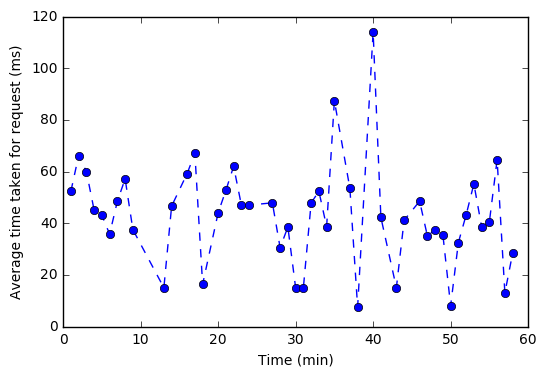

In [11]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(averagetime['Minutes'], averagetime['Time'], marker='o', linestyle='--')
plt.xlabel('Time (min)')
plt.ylabel('Average time taken for request (ms)')

With the help of Spark, Matplotlib, and a custom library, it becomes fairly easy to generate insights into the contents of a log file.